<h2>Time series from a toluene trial</h2>

In [3]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib

# Very important lines to run the setup notebooks!!!
%run do_plot_setup.ipynb
%run do_radical_count_setup.ipynb
get_cl_radical_budget = get_cl_radical_budget # Tautology to get rid of the yellow underlines
import cl2_utilities as cl2_utils
import process_cl2_logfile as process_cl2#This underline is unavoidable

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: DtypeWarning: Columns (38,46,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}


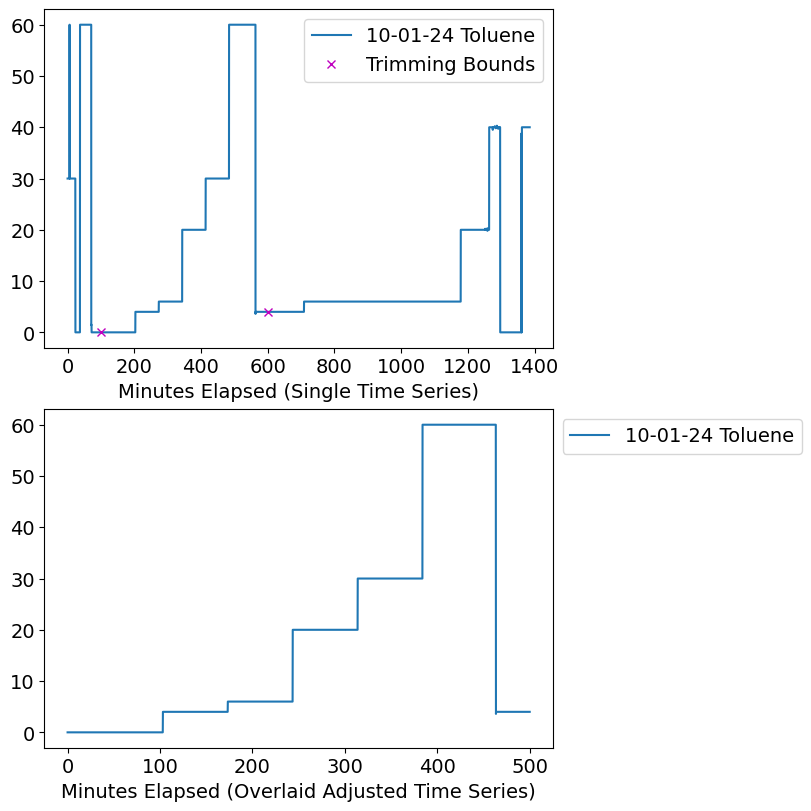

In [34]:
importlib.reload(process_cl2)
importlib.reload(cl2_utils)

# ************** START DATA PROCESSING ****************
path = (plot_default_properties['base_directory'] + '/09-29 Cl2 Campaign Redo 1/data/10-01-24_toluene.csv')
exp_name = '10-01-24 Toluene'
info = (path,exp_name,None)

# Load the file... (path,exp_name,ftir_path)
hush=True
raw_data = process_cl2.extract_data([info[:2]], hush)

#field = 'Cl2 LabJack: Cl2 Node A (mV)'
field = 'LF N2 MFC: Actual Flow'
importlib.reload(process_cl2)
trim_params = [(100, 600)]
(data, ax1, ax2) = process_cl2.trim_dataframes(raw_data, trim_params, plot=True, which_field=field, which_df=0)
rf = process_cl2.RemovalFinder(data, "01-16_cl2_misc_follow_ups")

importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-44.1)

def scale_cl2(mv):
    return (mv-44.1)*30/(77.7-44.1)

current_experiment = exp_name
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: ppm'] = scale_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
#plt.close()


30.089285714285708
5.000000000000002
25.089285714285708


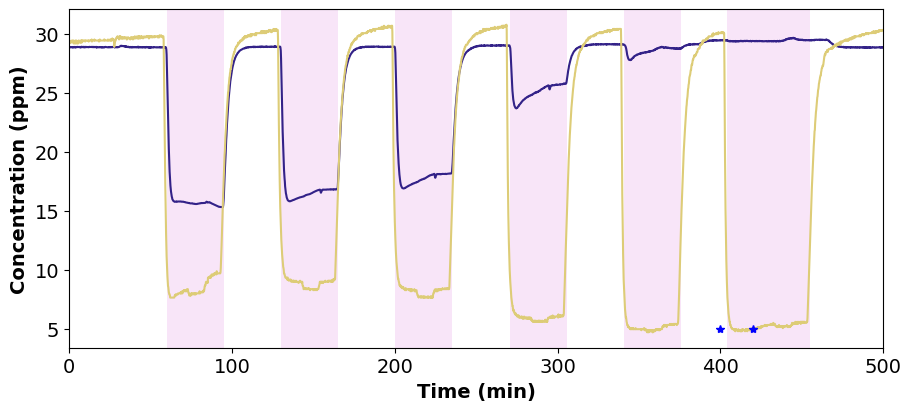

In [129]:
data_2ppm_time_series  = data[current_experiment]

# Plot the methane
min_offset = 0
(fig,ax_toluene_time_series)=plt.subplots(1,1,figsize=(9,4))
ax_toluene_time_series.plot(data_2ppm_time_series.Minutes-min_offset, data_2ppm_time_series['Picarro: CH4 (ppm)'], color=line_default_properties['CH4']['color'])
ax_toluene_time_series.plot(data_2ppm_time_series.Minutes-min_offset, data_2ppm_time_series['Cl2 LabJack: ppm'], color=line_default_properties['Cl2']['color'])
ax_toluene_time_series.set_xlim(0,500)
#ax_toluene_time_series.set_ylim(0,2.5)

# Add the UV light overlays
(on_times,off_times) = process_cl2.find_UV_changes(data[current_experiment]['UV Light: Actual Status'],data[current_experiment]['Minutes'])
on_times-=(min_offset-1.9)
off_times-=(min_offset-1.9)
for i in range(len(on_times)):
    ax_toluene_time_series.axvspan(on_times.iloc[i],off_times.iloc[i], color='m', alpha=0.1, lw=0)
#ax_toluene_time_series.text(.16,0.97, 'Light on →',ha='center',va='top',transform=ax_toluene_time_series.transAxes)
#ax_toluene_time_series.text(0.755,0.97, 'Light off →',ha='center',va='top',transform=ax_toluene_time_series.transAxes)
#ax_toluene_time_series.text(0.01,0.01,"2 ppm inlet CH$_4$\n2 ppm inlet Cl$_2$",ha='left',va='bottom',transform=ax_toluene_time_series.transAxes)
#ax_toluene_time_series.text(4,1.87,'CH$_4$',color=line_default_properties['CH4']['color'])
ax_toluene_time_series.set_ylabel("Concentration (ppm)",fontweight=plot_default_properties['font_weight'])
ax_toluene_time_series.set_xlabel("Time (min)",fontweight=plot_default_properties['font_weight'])

x = 400
y1 = np.interp(x,data_2ppm_time_series.Minutes-min_offset,data_2ppm_time_series['Cl2 LabJack: ppm'])
ax_toluene_time_series.plot(x,y,'b*')
print(y1)

x = 420
y2 = np.interp(x,data_2ppm_time_series.Minutes-min_offset,data_2ppm_time_series['Cl2 LabJack: ppm'])
ax_toluene_time_series.plot(x,y,'b*')
print(y2)

print(y1-y2)

plt.savefig('exported_images/time_series_2_ppm.png', bbox_inches='tight',dpi=300)
plt.show()


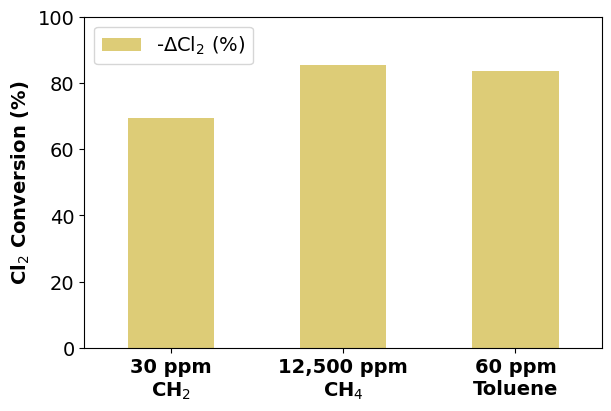

In [ ]:
# Select data from the experiments that we want
toluene_data = all_conversion_data[all_conversion_data["experiment_name"].isin(["10-01-24 Sweep Toluene"])]
toluene_data = toluene_data[toluene_data.start_time==396.17]

baseline_data = all_conversion_data[all_conversion_data["experiment_name"].isin(["09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"])]
baseline_data = baseline_data[baseline_data.start_time==212.48]

rad_count_data = all_conversion_data[all_conversion_data["experiment_name"].isin(["11-8-24 Radical Count High Range"])]
rad_count_data = rad_count_data[rad_count_data.start_time==158.92]

# Yay, we've got the data! Now let's make a bar graph.
(fig,ax)=plt.subplots(1,1,figsize=(6,4))

x = np.arange(3)
width = 0.5

cl2_baseline = np.array([float(x['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']) for x in [baseline_data, rad_count_data, toluene_data]])
cl2_conversions = np.array([float(x['Cl2 LabJack: Cl2 reading minus zero (mV) conversion']) for x in [baseline_data, rad_count_data, toluene_data]])
cl2_conversions_variance = np.array([float(x['Cl2 LabJack: Cl2 reading minus zero (mV) conversion variance due to noise']) for x in [baseline_data, rad_count_data, toluene_data]])
cl2_conversions_95_ci = 2*cl2_baseline*np.sqrt(cl2_conversions_variance)


bar_names = ['30 ppm\nCH$_2$','12,500 ppm\nCH$_4$','60 ppm\nToluene']
#data = 100*cl2_conversions/cl2_baseline
data = np.array([20.8, 0.5*51.2,25.1])#This is silly; just hardcode it
data = 100*data/30
ax.bar(x+0*width,data,width,color=line_default_properties['Cl2']['color'],hatch='',label='-$\Delta$Cl$_2$ (%)')
#ax.errorbar(x+0*width,cl2_conversions,cl2_conversions_95_ci,linestyle='None',color='k',capsize=3)
#ax.bar(x+1*width,current_data.cl_budget,width,color=line_default_properties['Cl2']['color'],hatch='xx',label='Total Cl$\\bullet$ produced (ppm)')
#ax.errorbar(x+1*width,current_data.cl_budget,current_data.cl_budget_95_ci,linestyle='None',color='k',capsize=3)

ax.set_ylabel("$\Delta$[X] (ppm)",fontweight=plot_default_properties['font_weight'])
ax.xaxis.set_tick_params(labelbottom=True)
right_ax_color = line_default_properties['Cl* Efficiency']['color']
ax.set_ylim(0,100)
ax.legend(loc='upper left')
ax.set_xticks(x + width, bar_names,fontweight=plot_default_properties['font_weight'])
ax.set_xlim(-0.5,2.5)

ax.set_ylabel("Cl$_2$ Conversion (%)",fontweight=plot_default_properties['font_weight'])
#ax.set_xlabel("Experiment",fontweight=plot_default_properties['font_weight'])
ax.set_xticks(x)
ax.set_xticklabels(bar_names)

# Plot the actual bars! In their proper colors!
# Error bars needed? Yes -- just hardcode them!
#   Getting error bars on the toluene will be mildly annoying but we ought to do it
# Label the experimental conditions using Text

plt.savefig('exported_images/compare_cl2_conversions.png', bbox_inches='tight',dpi=300)
plt.show()